In [43]:
# Importing data from the r/politics
from psaw import PushshiftAPI
import datetime
import pandas as pd
import os
import re
import numpy as np
from tqdm import tqdm
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer
from nltk.corpus import stopwords
from nltk import word_tokenize
import string
import matplotlib.pyplot as plt
import matplotlib as mpl
import matplotlib.dates as mdates
import requests
import io
import networkx as nx ; import netwulf as nw
from netwulf import visualize
from networkx import Graph
import random
import networkx.algorithms.community as nx_comm
from community import community_louvain

In [4]:
url_sub = "https://raw.githubusercontent.com/JaQtae/SocInfo2022/FinalProject/Data/politics_subs_big_fully_processed.csv"

download_sub = requests.get(url_sub).content

sub_data = pd.read_csv(io.StringIO(download_sub.decode('utf-8')), parse_dates = ['dates'], sep=',').set_index('dates')


url_com = "https://raw.githubusercontent.com/JaQtae/SocInfo2022/FinalProject/Data/com_data_50plusComments_pruned_30plusComments.csv"

download_com = requests.get(url_com).content

com_data = pd.read_csv(io.StringIO(download_com.decode('utf-8')), parse_dates = ['dates'], sep=',').set_index('dates')

sub_data = sub_data[sub_data.index > "2020-10-01"]


sub_data = sub_data[sub_data.index >= "2020-10-01"]

sub_data_to_remove = sub_data[sub_data.index < "2020-10-01"]

ids_to_remove = list(sub_data_to_remove["id"].values)

comments_to_delete = list(set(ids_to_remove))
for i in range(len(comments_to_delete)): 
    comments_to_delete[i] = 't3_' + comments_to_delete[i]
comments_to_delete

for i in range(len(comments_to_delete)):
    com_index = com_data[com_data['link_id'] == comments_to_delete[i]].index
    com_data = com_data.drop(com_index)
    
com_data = com_data.drop(com_data[com_data['parent_author'] == 'PoliticsModeratorBot'].index)

    
# Make sure all text bodies are of type string. 
com_data["body"] = com_data["body"].apply(str)
com_data

id    link_id  score           author   parent_id  \
dates                                                                         
2020-11-03 00:23:36  gaycvmz  t3_jmybs3      1        yyungpiss   t3_jmybs3   
2020-11-02 23:26:26  gay6kwb  t3_jmybs3      1     J_Class_Ford  t1_gay5x5w   
2020-11-02 23:20:27  gay5x5w  t3_jmybs3      1        cyanydeez  t1_gay5pjk   
2020-11-02 23:18:33  gay5pjk  t3_jmybs3      1     J_Class_Ford  t1_gay5doq   
2020-11-02 23:15:36  gay5doq  t3_jmybs3      1        cyanydeez  t1_gay3si8   
...                      ...        ...    ...              ...         ...   
2020-10-01 01:25:30  g78ozrz  t3_j2vwwt      1    5DollarHitJob   t3_j2vwwt   
2020-10-01 01:24:25  g78ovcd  t3_j2vwwt      1      AmishTechno   t3_j2vwwt   
2020-10-01 00:29:42  g78j6ey  t3_j2vwwt      1   ryhaltswhiskey  t1_g78iult   
2020-10-01 00:07:18  g78gwrv  t3_j2vwwt      1  GrumpyOlBastard   t3_j2vwwt   
2020-10-01 00:00:36  g78g8dl  t3_j2vwwt      1   maybe-fuck-you   t3_j2vwwt   

                                                                  body  \
dates                                                                    
2020-11-03 00:23:36  is there some sort of weird strategy to this o...   
2020-11-02 23:26:26                             Division is his weapon   
2020-11-02 23:20:27  dunno, everything trump does seems to generate...   
2020-11-02 23:18:33  Not sure it generates many more votes. I work ...   
2020-11-02 23:15:36  yeah, but for every vote this generates, would...   
...                                                                ...   
2020-10-01 01:25:30                         Can they just appeal this?   
2020-10-01 01:24:25                          And, nothing will happen.   
2020-10-01 00:29:42  Ah I did not know that\n\nMan I hope Barr ends...   
2020-10-01 00:07:18  So I’m wondering what’s going to happen when n...   
2020-10-01 00:00:36                              My report I paid for.   

                    parent_author  \
dates                               
2020-11-03 00:23:36        geoxol   
2020-11-02 23:26:26     cyanydeez   
2020-11-02 23:20:27  J_Class_Ford   
2020-11-02 23:18:33     cyanydeez   
2020-11-02 23:15:36  J_Class_Ford   
...                           ...   
2020-10-01 01:25:30    Plymouth03   
2020-10-01 01:24:25    Plymouth03   
2020-10-01 00:29:42   memepolizia   
2020-10-01 00:07:18    Plymouth03   
2020-10-01 00:00:36    Plymouth03   

                                                                tokens  \
dates                                                                    
2020-11-03 00:23:36  ['sort', 'weird', 'strategy', 'something', 'la...   
2020-11-02 23:26:26                             ['division', 'weapon']   
2020-11-02 23:20:27  ['dunno', 'everything', 'trump', 'seems', 'gen...   
2020-11-02 23:18:33  ['not', 'sure', 'generates', 'many', 'votes', ...   
2020-11-02 23:15:36  ['yeah', 'every', 'vote', 'generates', 'would'...   
...                                                                ...   
2020-10-01 01:25:30                                  ['can', 'appeal']   
2020-10-01 01:24:25                       ['and', 'nothing', 'happen']   
2020-10-01 00:29:42  ['ah', 'i', 'know', 'man', 'i', 'hope', 'barr'...   
2020-10-01 00:07:18  ['so', 'i', 'wondering', 'going', 'happen', 'n...   
2020-10-01 00:00:36                      ['my', 'report', 'i', 'paid']   

                    politician children_comments mentions_Trump mentions_Biden  
dates                                                                           
2020-11-03 00:23:36      Trump                []            NaN            NaN  
2020-11-02 23:26:26      Trump                []            NaN            NaN  
2020-11-02 23:20:27      Trump       ['gay6kwb']           True            NaN  
2020-11-02 23:18:33      Trump       ['gay5x5w']           True            NaN  
2020-11-02 23:15:36      Trump       ['gay5pjk']            NaN            NaN  
...                    

### Statistics of the submissions

We'll look into the distribution of the submissions mentioning either Trump or Biden. 

findfont: Font family ['Helvetica Neue'] not found. Falling back to DejaVu Sans.


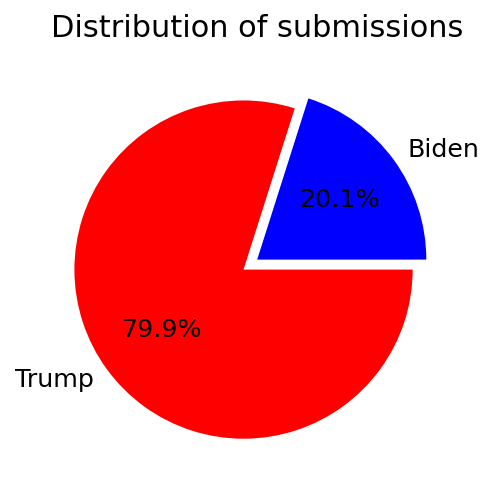

In [15]:
biden_trump_subs_dist = pd.DataFrame(sub_data.groupby("politician").count()["title"])
biden_trump_subs_dist = biden_trump_subs_dist.rename(columns = {"title" : " "})
#biden_trump_subs_dist
fig = plt.figure(dpi=140)
subs_dist_plot = biden_trump_subs_dist.plot.pie(y = " ", title = "Distribution of submissions", legend = False, colors = ["blue", "red"], shadow = False, autopct='%1.1f%%', explode=(0, 0.1), ax=plt.gca())
subs_dist_plot.figure.savefig("subs_distribution.png")

In [16]:
print("Total number of submissions: " + str(len(sub_data)))
print("Total number of submissions mentioning Trump: " + str(len(sub_data.loc[sub_data["politician"] == "Trump"])))
print("Total number of submissions mentioning Biden: " + str(len(sub_data.loc[sub_data["politician"] == "Biden"])))
print("Number of unique authors: " + str(len(sub_data["author"].unique())))
print("Average number of submissions per author: " + str(round(sub_data.groupby("author").count()["title"].mean(),2)))
print("Average number of comments per submission: " + str(round(sub_data["num_comments"].mean(), 1)))

Total number of submissions: 9018
Total number of submissions mentioning Trump: 7205
Total number of submissions mentioning Biden: 1813
Number of unique authors: 2912
Average number of submissions per author: 3.1
Average number of comments per submission: 150.5


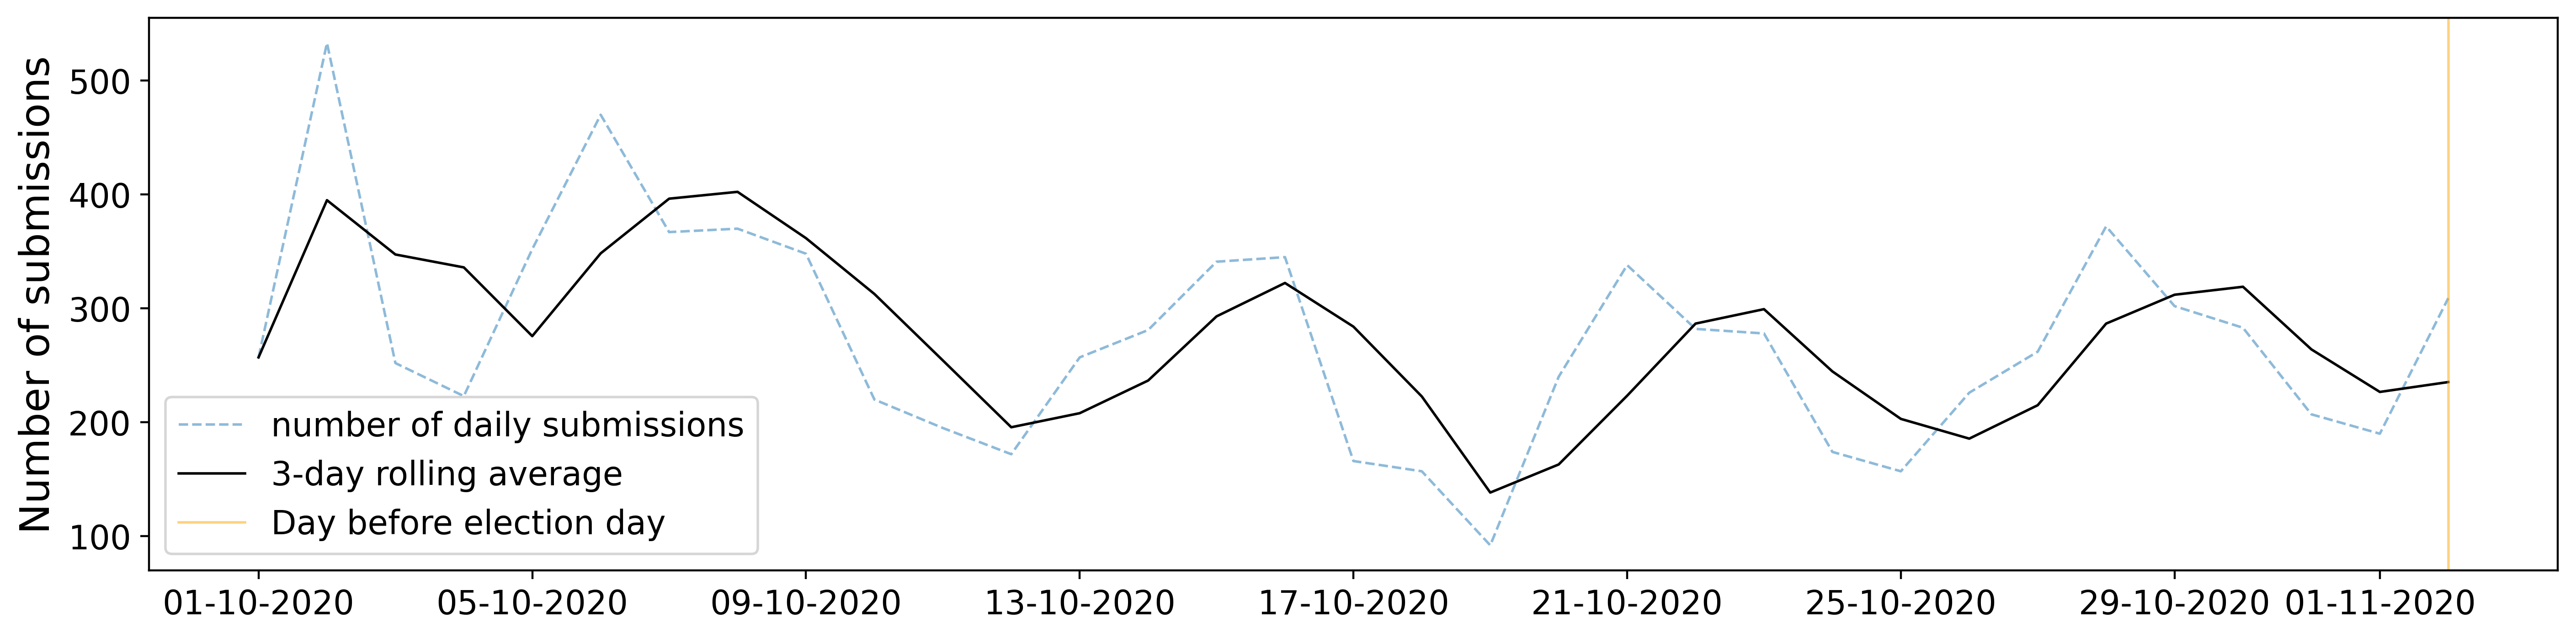

In [17]:
#We had some submissions befor the first of october
daily_subs = sub_data['id'].resample('D').count()
#Specifying the MatPlotLib font and line width
def setup_mpl():
    mpl.rcParams['font.family'] = 'Helvetica Neue'
    mpl.rcParams['font.size'] = '13'
    mpl.rcParams['lines.linewidth'] = 1
setup_mpl()
MyFmt = mdates.DateFormatter('%d-%m-%Y')
#Resample number of comments per day. 
#Convert to dataframe
daily_subs_df = pd.DataFrame(
                    {
                        'Daily submissions' : daily_subs.values
                    }, index = daily_subs.index)

MA_subs = daily_subs_df["Daily submissions"].rolling('3D').mean()
#Plot the moving average on top!

#fig, ax = plt.subplots(figsize=(15,5), dpi=400)
fig, ax = plt.subplots(figsize=(17,4), dpi=400)
ax.plot(daily_subs.index, daily_subs.values, ls = '--', alpha=0.5, label="number of daily submissions")
ax.plot(MA_subs.index, MA_subs.values, color='k', label="3-day rolling average")

ax.axvline(x=daily_subs.index[-1], label='Day before election day', color='orange', alpha=0.5)
#ax.plot(rolled_series.index, rolled_series.values, color='k', label="1 week rolling average")
ax.set_ylabel('Number of submissions', size = 16)
#ax.set_yscale('log')
ax.legend()
ax.xaxis.set_major_formatter(MyFmt)

plt.savefig('submissions_per_day_big.png', bbox_inches='tight')

In [18]:
sub_data[:3].drop(columns=["score"])

title  \
dates                                                                    
2020-11-02 22:54:58  Trump ramps up Fauci attacks on eve of electio...   
2020-11-02 22:48:58  Trump Loves To Declare Victory Even if He Didn...   
2020-11-02 22:46:57  Trump creates 1776 Commission to promote 'patr...   

                         id              author  num_comments  \
dates                                                           
2020-11-02 22:54:58  jmybs3              geoxol            33   
2020-11-02 22:48:58  jmy7vu  Facerealityalready            16   
2020-11-02 22:46:57  jmy6j9          bluestblue            53   

                                                                   url  \
dates                                                                    
2020-11-02 22:54:58  https://thehill.com/homenews/administration/52...   
2020-11-02 22:48:58  https://www.motherjones.com/politics/2020/11/t...   
2020-11-02 22:46:57  https://www.politico.com/news/2020/11/02/trump...   

                    politician  
dates                           
2020-11-02 22:54:58      Trump  
2020-11-02 22:48:58      Trump  
2020-11-02 22:46:57      Trump

### Statistics of the comments

# 3 Tools, theory and analysis

In [21]:
# Implementing the VADER sentiment analysis of the comments. 

#https://www.geeksforgeeks.org/python-sentiment-analysis-using-vader/
def calculate_compound_sentiment_score(sentence):

    # Create a SentimentIntensityAnalyzer object.
    sid_obj = SentimentIntensityAnalyzer()
 
    # polarity_scores method of SentimentIntensityAnalyzer
    # object gives a sentiment dictionary.
    # which contains pos, neg, neu, and compound scores.
    sentiment_dict = sid_obj.polarity_scores(sentence)
     
    # The Compound score is a metric that calculates the sum of all the lexicon ratings 
    # which have been normalized between -1(most extreme negative) and +1 (most extreme positive).   
    
    return sentiment_dict['compound']

In [22]:
tqdm.pandas()
com_data["compound_sentiment_score"] = com_data["body"].progress_apply(calculate_compound_sentiment_score)

100%|████████████████████████████████████████████████████████████████████████████| 95893/95893 [17:26<00:00, 91.64it/s]


In [33]:
#com_data.to_csv("politics_comments_big_with_sentiment.csv")

In [35]:
#com_data

In [23]:
test = com_data["body"][-2]
test = re.sub(r'\n', '', test)
test = re.sub(r'\'', '', test)
calculate_compound_sentiment_score('not bad good')
#test

0.1139

NOTE: Here, we've managed to delete even more comments leaving some authors with less than five comments. 

In [24]:
tqdm.pandas()
group = com_data.groupby(["author", "politician"])
#author_df_V = group.progress_apply(lambda x: x["compound_sentiment_score"].unique())


In [25]:
author_comments = group["body"].unique()
text = author_comments.values[0]

In [26]:
author_bodies = com_data.groupby(["author", "politician"]).apply(lambda x: x["body"].unique())

In [27]:
# Joining the comments for each politician for each of the authors
for i in tqdm(range(len(author_bodies.values))):
    author_bodies.values[i] = " ".join(list(author_bodies.values[i]))
    

100%|██████████████████████████████████████████████████████████████████████████| 3340/3340 [00:00<00:00, 119692.89it/s]


In [28]:
# List of unique comments authors
authors = list(com_data["author"].unique())

In [29]:
# Dict to contain the authors as keys and a dict as value: {"Biden" : compound sentiment score of the concatenated Biden-related comments, "Trump" : compound sentiment score of the concatenated Biden-related comments}
# Each list of sentiment scores contain 0 per default corresponding to a neutral compound sentiment. 
author_comment_sentiment_dict = {author : {"Biden" : 0, "Trump": 0} for author in authors}
for author in tqdm(authors):
    related_politicians = list(author_bodies[author].index)
    for politician in related_politicians:
        author_comment_sentiment_dict[author][politician] = calculate_compound_sentiment_score(author_bodies[author][politician])

100%|██████████████████████████████████████████████████████████████████████████████| 1741/1741 [04:47<00:00,  6.05it/s]


In [30]:
max(author_comment_sentiment_dict['cyanydeez'], key=author_comment_sentiment_dict['cyanydeez'].get)

'Biden'

In [31]:
author_conviction = pd.DataFrame({"author" : authors})

In [32]:
author_conviction["supporter_of"] = [max(author_comment_sentiment_dict[author], key=author_comment_sentiment_dict[author].get) for author in authors]
author_conviction

author supporter_of
0                yyungpiss        Biden
1             J_Class_Ford        Trump
2                cyanydeez        Biden
3                  Tesides        Biden
4         smurfsundermybed        Trump
...                    ...          ...
1736          fundropp8242        Biden
1737  TrumpVotersAre2Blame        Biden
1738  bleach_injector_2020        Biden
1739     FUCKLORD_SKYPUNCH        Biden
1740             muncher21        Biden

[1741 rows x 2 columns]

In [638]:
import requests 
import io
url_conviction = "https://raw.githubusercontent.com/JaQtae/SocInfo2022/FinalProject/Data/Saved dataframes etc/author_conviction_df.csv"

download_conviction = requests.get(url_conviction).content

author_conviction = pd.read_csv(io.StringIO(download_conviction.decode('utf-8')), parse_dates = ['Unnamed: 0'], sep=',').set_index('Unnamed: 0')
author_conviction.index = author_conviction.index.rename('index')
author_conviction

author supporter_of
index                                   
0                 yyungpiss        Biden
1              J_Class_Ford        Trump
2                 cyanydeez        Biden
3                   Tesides        Biden
4          smurfsundermybed        Trump
...                     ...          ...
1736     throwawaywriting12        Trump
1737           fundropp8242        Biden
1738   TrumpVotersAre2Blame        Trump
1739   bleach_injector_2020        Trump
1740              muncher21        Biden

[1741 rows x 2 columns]

In [639]:
url_com = "https://raw.githubusercontent.com/JaQtae/SocInfo2022/FinalProject/Data/FINAL_COMMENTS.csv"

download_com = requests.get(url_com).content

com_data = pd.read_csv(io.StringIO(download_com.decode('utf-8')), parse_dates = ['dates'], sep=',').set_index('dates')
com_data

id    link_id  score           author   parent_id  \
dates                                                                         
2020-11-02 23:26:26  gay6kwb  t3_jmybs3      1     J_Class_Ford  t1_gay5x5w   
2020-11-02 23:20:27  gay5x5w  t3_jmybs3      1        cyanydeez  t1_gay5pjk   
2020-11-02 23:18:33  gay5pjk  t3_jmybs3      1     J_Class_Ford  t1_gay5doq   
2020-11-02 23:15:36  gay5doq  t3_jmybs3      1        cyanydeez  t1_gay3si8   
2020-11-02 23:04:18  gay43vt  t3_jmybs3      1          Tesides   t3_jmybs3   
...                      ...        ...    ...              ...         ...   
2020-10-01 01:25:30  g78ozrz  t3_j2vwwt      1    5DollarHitJob   t3_j2vwwt   
2020-10-01 01:24:25  g78ovcd  t3_j2vwwt      1      AmishTechno   t3_j2vwwt   
2020-10-01 00:29:42  g78j6ey  t3_j2vwwt      1   ryhaltswhiskey  t1_g78iult   
2020-10-01 00:07:18  g78gwrv  t3_j2vwwt      1  GrumpyOlBastard   t3_j2vwwt   
2020-10-01 00:00:36  g78g8dl  t3_j2vwwt      1   maybe-fuck-you   t3_j2vwwt   

                                                                  body  \
dates                                                                    
2020-11-02 23:26:26                             Division is his weapon   
2020-11-02 23:20:27  dunno, everything trump does seems to generate...   
2020-11-02 23:18:33  Not sure it generates many more votes. I work ...   
2020-11-02 23:15:36  yeah, but for every vote this generates, would...   
2020-11-02 23:04:18  I really do believe this idiot is trying to lo...   
...                                                                ...   
2020-10-01 01:25:30                         Can they just appeal this?   
2020-10-01 01:24:25                          And, nothing will happen.   
2020-10-01 00:29:42  Ah I did not know that\n\nMan I hope Barr ends...   
2020-10-01 00:07:18  So I’m wondering what’s going to happen when n...   
2020-10-01 00:00:36                              My report I paid for.   

                    parent_author  \
dates                               
2020-11-02 23:26:26     cyanydeez   
2020-11-02 23:20:27  J_Class_Ford   
2020-11-02 23:18:33     cyanydeez   
2020-11-02 23:15:36  J_Class_Ford   
2020-11-02 23:04:18        geoxol   
...                           ...   
2020-10-01 01:25:30    Plymouth03   
2020-10-01 01:24:25    Plymouth03   
2020-10-01 00:29:42   memepolizia   
2020-10-01 00:07:18    Plymouth03   
2020-10-01 00:00:36    Plymouth03   

                                                                tokens  \
dates                                                                    
2020-11-02 23:26:26                             ['division', 'weapon']   
2020-11-02 23:20:27  ['dunno', 'everything', 'trump', 'seems', 'gen...   
2020-11-02 23:18:33  ['not', 'sure', 'generates', 'many', 'votes', ...   
2020-11-02 23:15:36  ['yeah', 'every', 'vote', 'generates', 'would'...   
2020-11-02 23:04:18  ['i', 'really', 'believe', 'idiot', 'trying', ...   
...                                                                ...   
2020-10-01 01:25:30                                  ['can', 'appeal']   
2020-10-01 01:24:25                       ['and', 'nothing', 'happen']   
2020-10-01 00:29:42  ['ah', 'i', 'know', 'man', 'i', 'hope', 'barr'...   
2020-10-01 00:07:18  ['so', 'i', 'wondering', 'going', 'happen', 'n...   
2020-10-01 00:00:36                      ['my', 'report', 'i', 'paid']   

                    politician children_comments mentions_Trump  \
dates                                                             
2020-11-02 23:26:26      Trump                []            NaN   
2020-11-02 23:20:27      Trump       ['gay6kwb']           True   
2020-11-02 23:18:33      Trump       ['gay5x5w']           True   
2020-11-02 23:15:36      Trump       ['gay5pjk']            NaN   
2020-11-02 23:04:18      Trump                []            NaN   
...                        ...               ...            ...   
2020-10-01 01:25:30      Trump                []      

In [640]:
edges = com_data.drop(['id', 'link_id', 'parent_id','body','tokens','politician','children_comments','mentions_Trump', 'mentions_Biden', 'compound_sentiment_score'], axis=1)
edges = com_data.groupby(['author', 'parent_author']).count()
edges

id  link_id  score  parent_id  body  \
author              parent_author                                          
---------_----_---_ 1PositiveKarma1   1        1      1          1     1   
                    2wedfgdfgfgfg     1        1      1          1     1   
                    66fenderjazz      1        1      1          1     1   
                    ANTristotle       1        1      1          1     1   
                    AmishAvenger      1        1      1          1     1   
...                                  ..      ...    ...        ...   ...   
zubbs99             westondeboer      1        1      1          1     1   
                    wrapityup         1        1      1          1     1   
                    wrldtrvlr3000     1        1      1          1     1   
                    xTemporaneously   1        1      1          1     1   
                    zztop610          1        1      1          1     1   

                                     tokens  politician  children_comments  \
author              parent_author                                            
---------_----_---_ 1PositiveKarma1       1           1                  1   
                    2wedfgdfgfgfg         1           1                  1   
                    66fenderjazz          1           1                  1   
                    ANTristotle           1           1                  1   
                    AmishAvenger          1           1                  1   
...                                     ...         ...                ...   
zubbs99             westondeboer          1           1                  1   
                    wrapityup             1           1                  1   
                    wrldtrvlr3000         1           1                  1   
                    xTemporaneously       1           1                  1   
                    zztop610              1           1                  1   

                                     mentions_Trump  mentions_Biden  \
author              parent_author                                     
---------_----_---_ 1PositiveKarma1               0               0   
                    2wedfgdfgfgfg                 0               0   
                    66fenderjazz                  0               0   
                    ANTristotle                   0               0   
                    AmishAvenger                  0               0   
...                                             ...             ...   
zubbs99             westondeboer                  0               0   
                    wrapityup                     0               0   
                    wrldtrvlr3000                 0               0   
                    xTemporaneously               0               0   
                    zztop610                      0               0   

                                     compound_sentiment_score  
author              parent_author                              
---------_----_---_ 1PositiveKarma1                         1  
                    2wedfgdfgfgfg                           1  
                    66fenderjazz                            1  
                    ANTristotle                             1  
                    AmishAvenger                            1  
...                                                       ...  
zubbs99             westondeboer                            1  
                    wrapityup                               1  
                    wrldtrvlr3000                           1  
                    xTemporaneously                         1  
                    zztop610                                1  

[82643 rows x 11 columns]

#In order to model the interactions of the redditors with one another, we constructed an undirected network based on their 
comments and replies, where all nodes were the authors. We then created reciprocal edges such that each edge represented 
that the two authors had replied to the other at least once. Aftewards we assigned an edge weight based on the total number of
comments the two authors had written to one another. Finally we removed all singleton nodes and self-loops from the graph. These methods were chosen as we would like to focus on discussions where both users interacted with one another and contributed to a dialogue in order to make some conclusion about political 
discussions online. In that case making the network undirected would simplify it and make it easier to plot.

In [683]:
# We make a directed graph. 
edges = com_data.drop(['id', 'link_id', 'parent_id','body','tokens','politician','children_comments','mentions_Trump', 'mentions_Biden', 'compound_sentiment_score'], axis=1)
edges = com_data.groupby(['author', 'parent_author']).count()
#print(edges)
#print(edges.loc[edges['author'] == 'yyungpiss'])

G = nx.DiGraph()

# Add all edges and remake to reciprocal.

G.add_weighted_edges_from([ (a, b, edges['score'].loc[(a,b)]) for a, b in edges.index])                           
#G = nx.path_graph(10)
#G.add_edges_from((a,b) for a,b in edges.index)

G_U = G.to_undirected(reciprocal=True)

for node, ngbr, w in G_U.edges.data('weight'):
#     Undirected edge weights equal to sum of weights in two corresponding directed edges
    G_U.edges[node, ngbr]['weight'] = (G.edges[node, ngbr]['weight'] + G.edges[ngbr, node]['weight'])

# Finally, remove isolated nodes and self-loops in graph.
G_U.remove_edges_from(nx.selfloop_edges(G_U))

G_U.remove_nodes_from(list(nx.isolates(G_U))) 

Original_G_U_edges = G_U.edges()


print('Nodes: {}'.format(G_U.number_of_nodes()))
print('Edges: {}'.format(G_U.number_of_edges()))



Nodes: 1346
Edges: 3395


In [719]:
#The political conviction of authors is an important part of our analysis, therefore we add it as a node attribute in our network: 

#(Kan skrives sammen med teksten øverst om netværket)
author_list = list(author_conviction['author'].values)


node_list = list(G_U.nodes())



for i in tqdm(range(len(node_list))): 
    if node_list[i] in author_list: 

        G_U.nodes[node_list[i]]['conviction'] = list(author_conviction.loc[author_conviction['author'] == node_list[i]]['supporter_of'].values)[0]
    else: 
        G_U.nodes[node_list[i]]['conviction'] = 'Unknown'


100%|████████████████████████████████████████████████████████████████████████████| 1346/1346 [00:00<00:00, 2546.41it/s]


We see that 474 of the nodes have the conviction attribute 'Trump' and 872 have the attribute 'Biden'

In [721]:
Trump_nodes = [n for n,v in G_U.nodes(data=True) if v['conviction'] == 'Trump']
Biden_nodes = [n for n,v in G_U.nodes(data=True) if v['conviction'] == 'Biden']
print(len(Trump_nodes))
print(len(Biden_nodes)) 

474
872


#One of our goals was to investigate if authors primarily interacted with other users of similar political conviction. Therefore as a preliminary analysis we calculate the fraction of edge weights between authors with the same political conviction. We find that around 56% of the comments were written to a user that shared the political conviction of the author. This could suggest that the users communicate slightly more often with people that share their political belief, as this might be easier and leads to a less polarizing discussion. However they still interact relatively broadly - often with someone they disagree with politically - as political disagreement might give users a larger incentive to reply to a comment. It is also important to keep in mind that there are some shortcomings in our assumptions of the users opinions however, as it was inferred from the sentiment and do not represent a ground truth. Therefore they might be different from the users' true political opinions which might cause some shortcomings for our later analysis. 


In [705]:
interactions_with_likeminded_users = []

total_interactions = []

for i in tqdm(range(len(node_list))):
    
    own_conviction = G_U.nodes[node_list[i]]['conviction']

    neighbor_list = [n for n in G_U.neighbors(node_list[i])]
    for neighbor in neighbor_list: 
        neighbor_conviction = G_U.nodes[neighbor]['conviction']
        if neighbor_conviction == own_conviction: 
            interactions_with_likeminded_users.append(list(G.edges()[(node_list[i], neighbor)].values())[0])
            total_interactions.append(list(G.edges()[(node_list[i], neighbor)].values())[0])
            
        else: 
            total_interactions.append(list(G.edges()[(node_list[i], neighbor)].values())[0])
  #  print(list(G.edges()[(node_list[i], neighbor)].values())[0])
#print(len(total_interactions))
#print(sum(interactions_with_likeminded_users))
print(sum(interactions_with_likeminded_users)/sum(total_interactions))
        

100%|███████████████████████████████████████████████████████████████████████████| 1346/1346 [00:00<00:00, 48200.51it/s]

0.565470417070805


In [381]:
#import networkx as nx; 

#nx.write_gexf(G_U, 'politics_network_correct.gexf')



We then visualised the network using the Netwulf package. Nodes with the political conviction attribute "Trump" were colored red while nodes with the attribute "Biden" are blue. We also varied the size of the nodes proportional to their strength, which in this case was the sum of the weights of the node's edges. Lastly we displayed the names of the 8 users with the largest degree as text labels.

100%|██████████████████████████████████████████████████████████████████████████| 1346/1346 [00:00<00:00, 192818.51it/s]
----------------------------------------
Exception happened during processing of request from ('127.0.0.1', 61003)
Traceback (most recent call last):
  File "C:\Shared\anaconda3\lib\socketserver.py", line 316, in _handle_request_noblock
    self.process_request(request, client_address)
  File "C:\Shared\anaconda3\lib\socketserver.py", line 347, in process_request
    self.finish_request(request, client_address)
  File "C:\Shared\anaconda3\lib\socketserver.py", line 360, in finish_request
    self.RequestHandlerClass(request, client_address, self)
  File "C:\Shared\anaconda3\lib\http\server.py", line 647, in __init__
    super().__init__(*args, **kwargs)
  File "C:\Shared\anaconda3\lib\socketserver.py", line 720, in __init__
    self.handle()
  File "C:\Shared\anaconda3\lib\http\server.py", line 427, in handle
    self.handle_one_request()
  File "C:\Shared\anaconda3\l

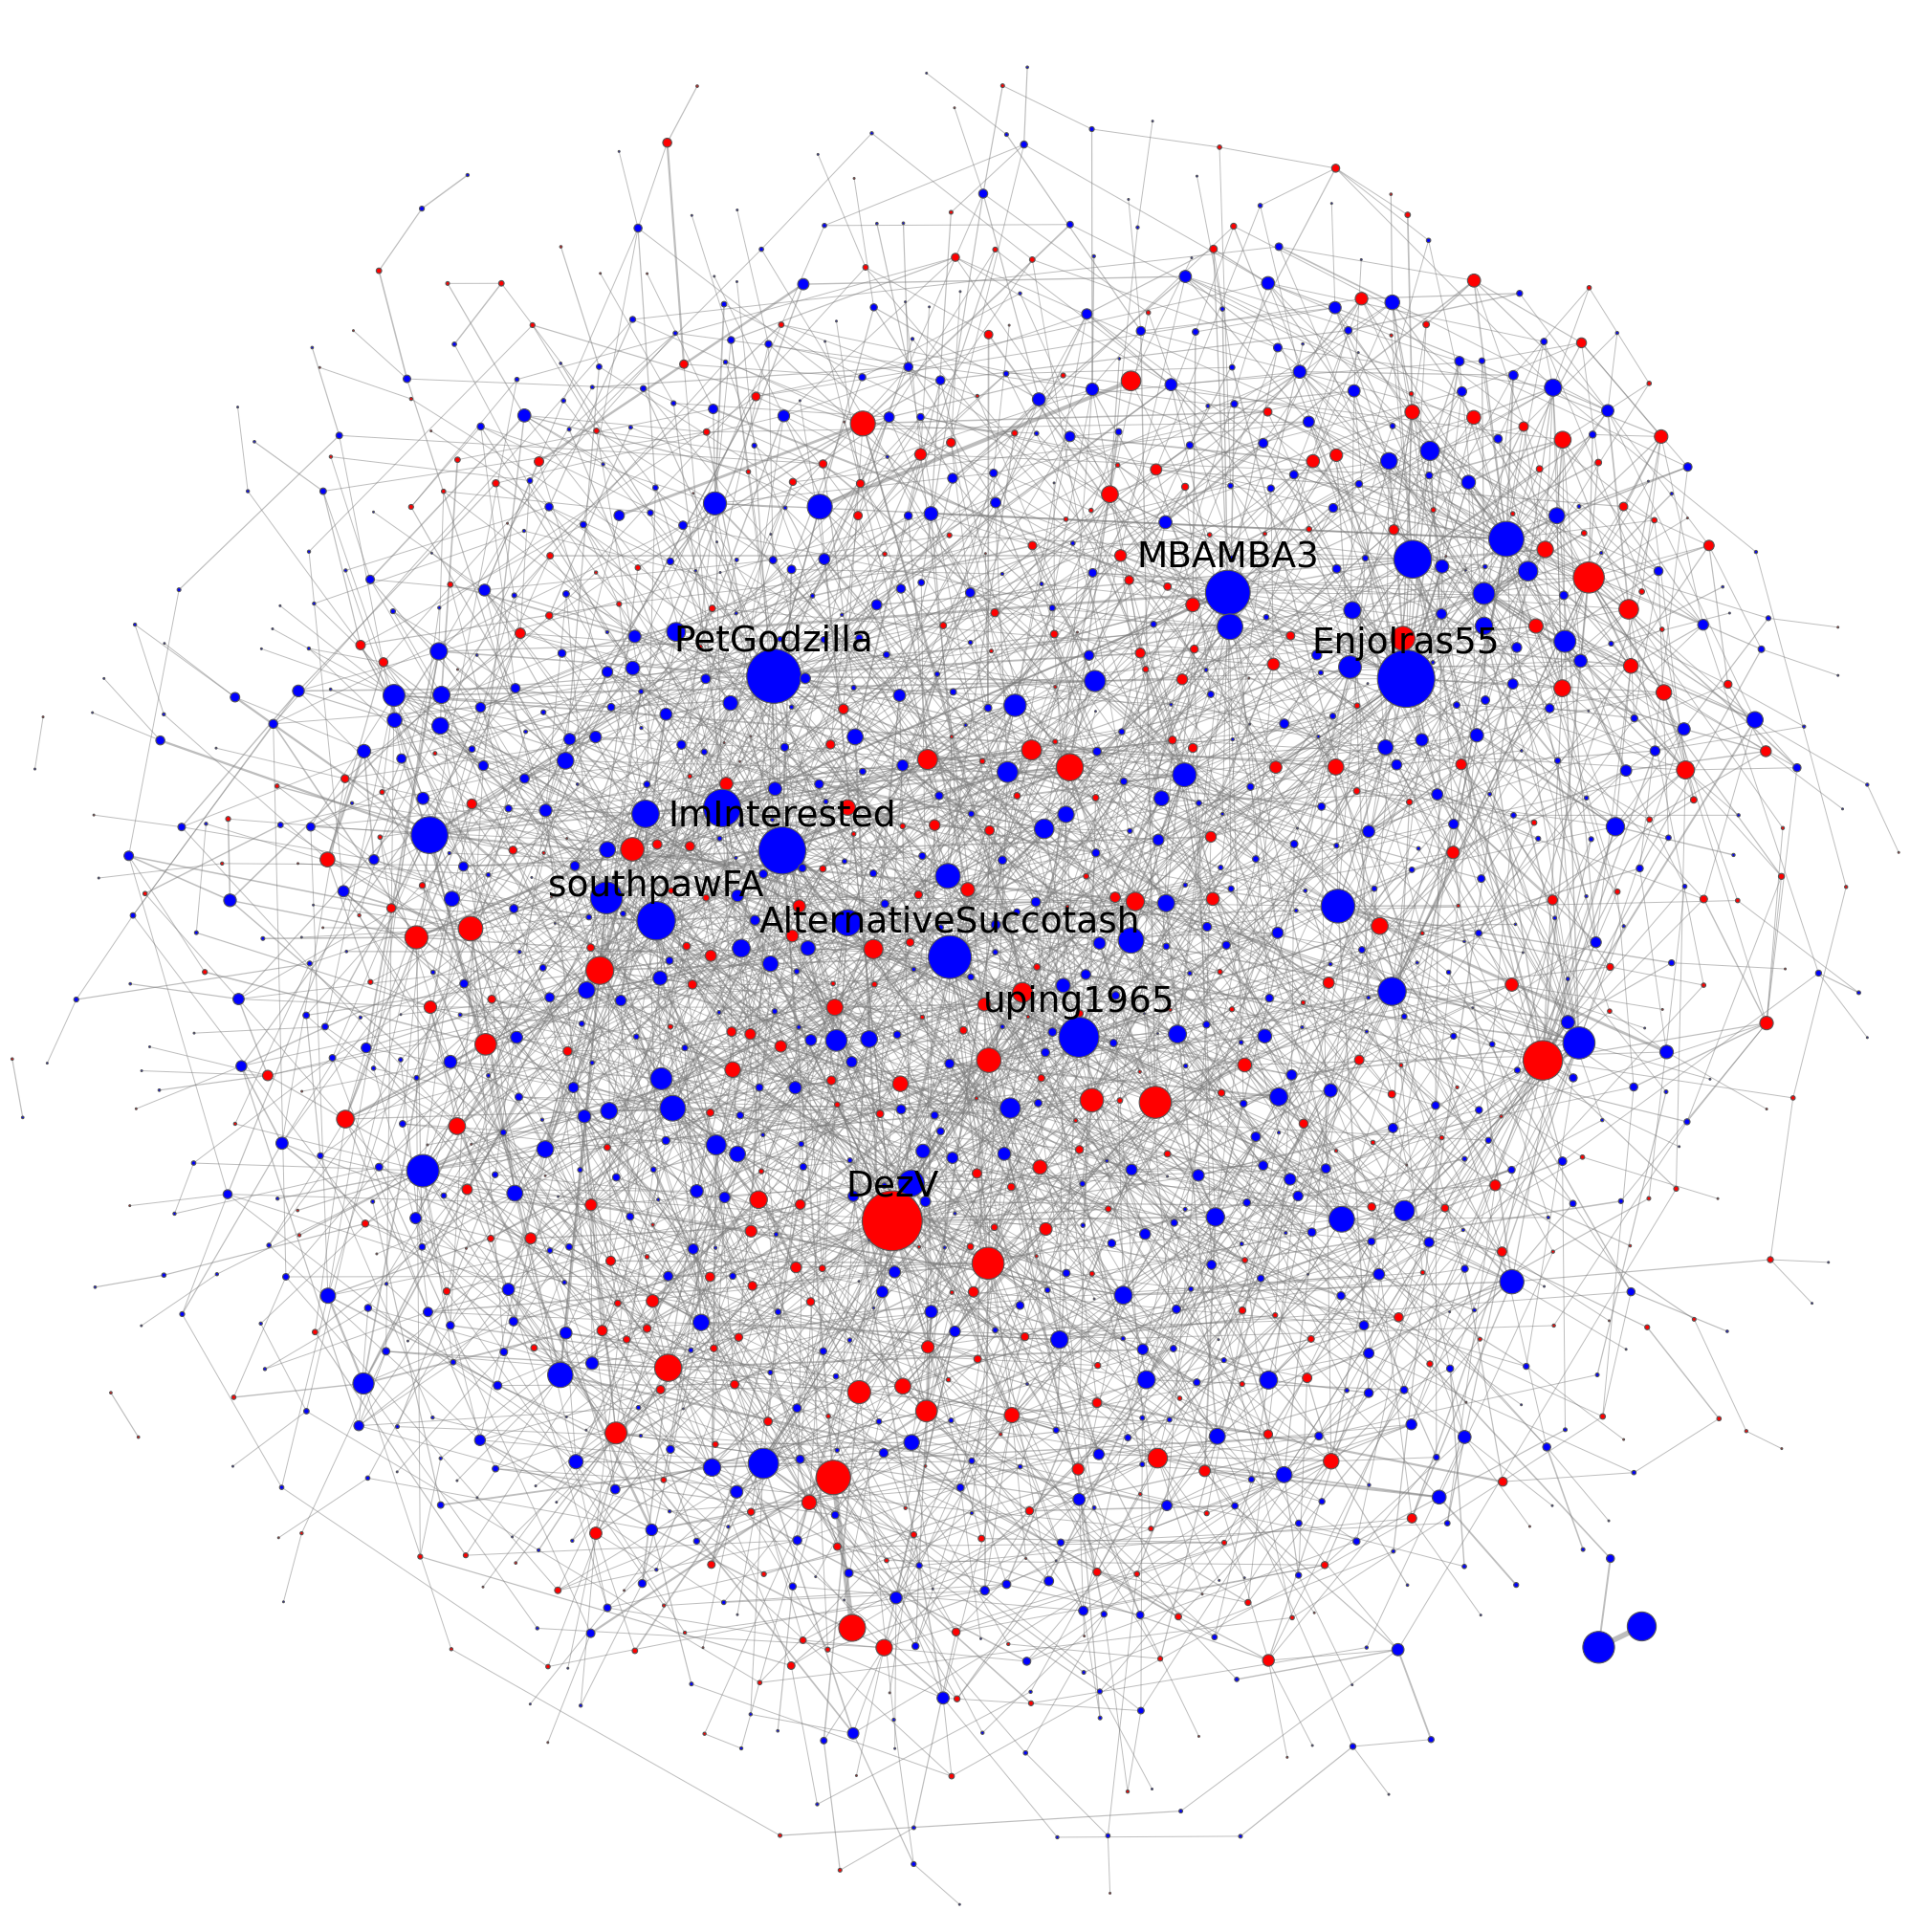

In [708]:


for i in tqdm(range(len(node_list))):
    conviction = G_U.nodes[node_list[i]]['conviction']
    if conviction == 'Trump':
        G_U.nodes[node_list[i]]['color'] = '#FF0000'
    if conviction == 'Biden':
        G_U.nodes[node_list[i]]['color'] = '#0000FF'


largest_degree_labels = []
largest_degree_nodes = sorted(G_U.degree, key=lambda x: x[1], reverse=True)[:8]
for i in range(len(largest_degree_nodes)): 
    largest_degree_labels.append(largest_degree_nodes[i][0])


#G_U = nx.read_gexf("com_network.gexf")

plt.style.use('default')


configuration = {"zoom": 1.15, "node_charge": -30, "node_gravity": 0.4,
                 "link_distance": 15, "link_distance_variation": 0, "node_collision": True,
                 "wiggle_nodes": False, "freeze_nodes": False,
                 "node_fill_color": '#79aaa0', "node_stroke_color": "#555555",
                 "node_label_color": "#000000","node_size": 10,"node_stroke_width": 0.4,
                 "node_size_variation": 0.8, "label_size": 10, "display_node_labels": False,
                 "scale_node_size_by_strength": True,"link_color": "#7c7c7c", "link_width": 2,
                 "link_alpha": 0.5, "link_width_variation": 0.5, "display_singleton_nodes": True,
                 "min_link_weight_percentile": 0,"max_link_weight_percentile": 1}


network, config = nw.visualize(G_U, plot_in_cell_below=False, config = configuration)

fig, ax = nw.draw_netwulf(network, figsize = 20)

for label in largest_degree_labels: 
    nw.add_node_label(ax,network,label, dy = 15, fontsize = 27)
    
#plt.savefig('politics_network.svg', bbox_inches='tight')

#with plt.style.context('classic'):
 #  network, config = nw.interactive.visualize(nw.get_filtered_network(G_U, node_group_key='conviction'),  plot_in_cell_below=False)
  # fig, ax = nw.draw_netwulf(network, config = configuration)


#From the graph we observe that the red and blue nodes are quite interconnected, and there doesn't seem to be two distinct communities for the supporters of Trump and Biden. This supports our calculations from earlier, but is also investigated in the later analysis. In some cases we observe a number of interconnected blue nodes, but these hubs might also appear because there are significantly more blue 'Biden' nodes than red nodes, 872 vs 474 respectively.  

As seen in the figure, most of the nodes only have a few edges, while some nodes have a large degree. This might correspond to a few popular authors that interact mutually with many of the users. Most of the users only have a single mutual social connection. This is common for a real social network and will be investigated further in the next section.

# Degree distribution

As a part of our analysis we investigated the degree distribution of the authors in our Reddit network, by plotting the probability density for the degrees in a histogram. This was also done to see if our distribution is similar to the ones encountered in other social networks. 

minDeg: 1 | maxDeg: 50


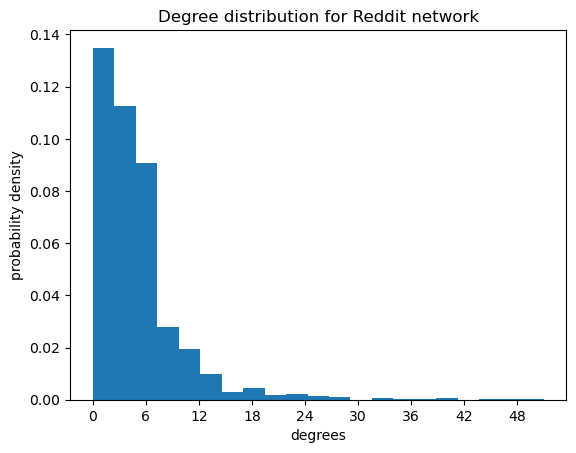

In [722]:
#Degree distribution for our network:

degReddit = [x[1] for x in G_U.degree]
print('minDeg: {} | maxDeg: {}'.format(min(degReddit), max(degReddit)))
bins = np.linspace(0, 51, 22)
hist, edges = np.histogram(degReddit, bins=bins, density=True)
x = (edges[1:]+edges[:-1])/2
width = bins[1] - bins[0]
#plt.style.use('dark_background')
fig, ax = plt.subplots()
plt.title("Degree distribution for Reddit network")
ax.bar(x, hist, width=width)
ax.set_ylabel("probability density")
ax.set_xlabel("degrees")
ax.xaxis.set_major_locator(plt.MaxNLocator(10))

plt.savefig('degree_distribution_for_Reddit_network.svg', bbox_inches='tight')

It is observed that the probability mass is the highest for small degrees but then drops off rapidly for a larger amount of degrees. This could have the appearance of a power-law distribution, which is common for real social networks, and also supports what is mentiond Chapter 3 in the NS book. 
As a reference we compare it a similar randomly constructed Erdos Renyi network. The random network contains the same number of nodes and links, where the probability of two nodes sharing an edge is constant and has been derived from formula 3.3 in Chapter of the NS book.  

In [709]:
L = len(G_U.edges)
N = len(G_U.nodes)
print(N)

p = 2*L/(N*(N-1))
print(f'p={p * 100:.2f}%')
k = 2*L/N
print('k: {:.3f}'.format(k))

1346
p=0.38%
k: 5.045


In [648]:
Random_graph = nx.generators.random_graphs.erdos_renyi_graph(N,p, seed = 42)

minDeg: 0 | maxDeg: 13


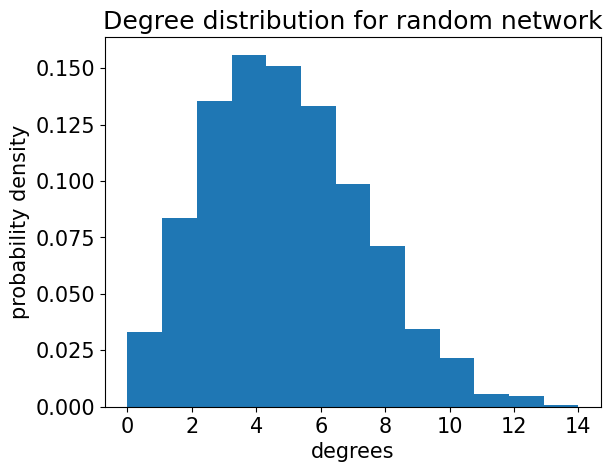

In [649]:
plt.style.use('default')

def setup_mpl():
    #mpl.rcParams['font.family'] = 'Helvetica Neue'
    mpl.rcParams['font.size'] = '15'
    mpl.rcParams['lines.linewidth'] = 3
setup_mpl()


#Degree distribution for random network:


degrees = [x[1] for x in Random_graph.degree]
print('minDeg: {} | maxDeg: {}'.format(min(degrees), max(degrees)))
bins = np.linspace(0, 14, 14)
hist_random, edges = np.histogram(degrees, bins=bins, density=True)
x_random = (edges[1:]+edges[:-1])/2
width = bins[1] - bins[0]
#plt.style.use('dark_background')
fig, ax = plt.subplots()
plt.title("Degree distribution for random network")
ax.bar(x_random, hist_random, width=width)
ax.set_ylabel("probability density")
ax.set_xlabel("degrees")
ax.xaxis.set_major_locator(plt.MaxNLocator(10))
plt.savefig('degree_distribution_for_random_network.svg', bbox_inches='tight')


The degree distribution for the random network is therefore evidently binomial and peaks close to the mean degree of 5.045 

We then plot the degree distribution of our Reddit network and the random network together in a log-scale plot to compare them. 

minDeg: 1 | maxDeg: 50


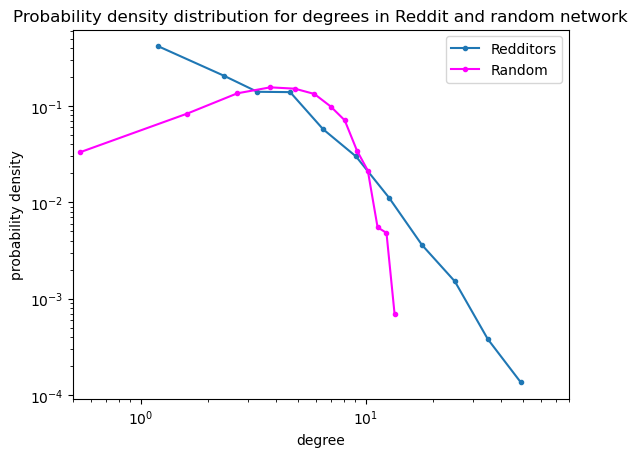

In [723]:
#Degree distribution for the reddit network:
degReddit = [x[1] for x in G_U.degree]
print('minDeg: {} | maxDeg: {}'.format(min(degReddit), max(degReddit)))
bins_reddit = np.logspace(0, np.log10(80), 14)
hist_reddit, edges_reddit = np.histogram(degReddit, bins=bins_reddit, density=True)
x_reddit = (edges_reddit[1:]+edges_reddit[:-1])/2
fig, ax = plt.subplots()
xx, yy = zip(*[(i,j) for (i,j) in zip(x_reddit, hist_reddit) if j > 0])

#The two distributions as log scale: 
xx_random, yy_random = zip(*[(i,j) for (i,j) in zip(x_random, hist_random) if j > 0])

x, hist = zip(*[(i,j) for (i,j) in zip(x, hist) if j > 0])

plt.plot(xx, yy, marker='.', label="Redditors")
plt.plot(xx_random, yy_random, marker='.', color='magenta', label="Random")
plt.title("Probability density distribution for degrees in Reddit and random network")
plt.ylabel("probability density")
plt.xlabel("degree")
plt.legend()
plt.yscale('log')
plt.xscale('log')
plt.xlim((0.5, 80))

plt.savefig('probability_density_distibution_degrees_for_Reddit_and_random_network.svg', bbox_inches='tight')

For the random network the probability mass is condensed at a smaller area with the density dropping of significantly after its peak around degree 5. Also it is interesting to observe that no nodes have a degree larger than 13. 

On the other hand the distribution for the real Reddit network is significantly more heavy-tailed with the largest observed degree being 51. As mentioned earlier the probability density of the degrees does not follow a poisson or binomial distribution, but instead approximately follows a power-law distribution. All of this was done to further examine the interactions between the users and we can conclude that the networks degree distribution more commonly associated with real social networks and is significantly different from that of a random network, which is intuitive.

minDeg: 1 | maxDeg: 50


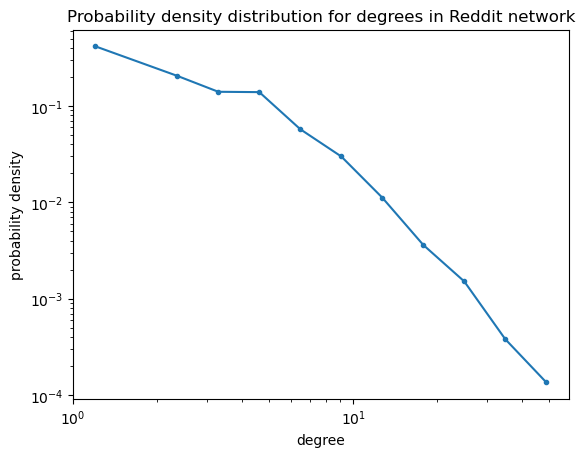

In [724]:
#Degree distribution for the reddit network:
degReddit = [x[1] for x in G_U.degree]
print('minDeg: {} | maxDeg: {}'.format(min(degReddit), max(degReddit)))
bins_reddit = np.logspace(0, np.log10(80), 14)
hist_reddit, edges_reddit = np.histogram(degReddit, bins=bins_reddit, density=True)
x_reddit = (edges_reddit[1:]+edges_reddit[:-1])/2
fig, ax = plt.subplots()
xx, yy = zip(*[(i,j) for (i,j) in zip(x_reddit, hist_reddit) if j > 0])
ax.plot(xx, yy, marker='.')
plt.title("Probability density distribution for degrees in Reddit network")
ax.set_ylabel("probability density")
ax.set_xlabel("degree")
ax.set_yscale('log')
ax.set_xscale('log')

plt.savefig('probability_density_distibution_degrees_for_Reddit_network.svg', bbox_inches='tight')

# Clustering

Next we calculated the clustering coefficient for our network. This measures the density of links in node i’s immediate neighborhood on a scale from 0 to 1, for instance Ci = 0 would mean that there are no links between i’s neighbors; Ci = 1 implies that each of the i’s neighbors link to each other to investigate the general interconnectedness. Therefore it would tell us if one author just interacted with number of "seperated" users or if the hub is more akin to a "community" where the neighbors also reply to each other. 
The clustering coefficient is first calculated using the left-hand side of formula 3.21 in Section 3 of the NS book and the method provided in the networkx package. It was then compared with the approximative formula Ci = <k>/N, which works well for random networks. 

In [ ]:
C = []
for node in G_U.nodes():
    neighbors = G_U.neighbors(node)
    subgraph_neighbors = G_U.subgraph(neighbors).copy()
    L_i = len(subgraph_neighbors.edges)
    k_i = G_U.degree(node)
    #We use the formula 3.21
    C.append((2*L_i) / (k_i * (k_i - 1) + 1e-6)) #Few nodes only have k_i = 1
    
lst = list(nx.clustering(G_U).values())
lst = [float(i) for i in lst]

In [725]:
np.mean(C), np.mean(lst), np.mean(degReddit)/len(degReddit)

(0.016888500959335504, 0.016888504285936627, 0.0037478280260261542)

We observe that the real clustering coefficient in the network is significantly higher than the one approximated with the right hand side of formula 3.21, Ci = <k>/N. This also supports the theory mentioned in Chapter 3 of the NS book. However the value itself is relatively low, which supports the hypothesis that a few active authors have a large number of connections, but their neighbors are often not connected.    

As a reference we run the same procedure on the random network. 

In [727]:
C = []
for node in Random_graph.nodes():
    neighbors = Random_graph.neighbors(node)
    subgraph_neighbors = Random_graph.subgraph(neighbors).copy()
    L_i = len(subgraph_neighbors.edges)
    C.append((2*L_i) / (Random_graph.degree(node) * (Random_graph.degree(node) - 1) + 1e-6)) #Few notes have 


In [728]:
lst = list(nx.clustering(Random_graph).values())
lst = [float(i) for i in lst]

In [729]:
np.mean(lst), np.mean(C), np.mean(degrees) / len(degrees)

(0.003156324441614189, 0.0031563242780291664, 0.0037522437291496015)

First of all the clustering coefficient is generally significantly lower, and the approximation is also closer to the real clustering coefficient. All of this signifies that our network follows the properties of a real social network and not those of a random network.

# Shortest path - is the reddit network a small world network

We calculated the average shortest path length for all nodes in the largest connected component in our network to investigate it follows the 'small world' property of social networks. 

In [730]:
#Get all components
CCs_reddit = [len(c) for c in sorted(nx.connected_components(G_U), key=len, reverse=True)]
largest_cc_reddit = max(nx.connected_components(G_U), key=len)
print(f'Number of components: {len(CCs_reddit)}')
print(f'The largest connected component contains: {len(largest_cc_reddit)}')

Number of components: 4
The largest connected component contains: 1340


In [731]:
S_reddit = G_U.subgraph(largest_cc_reddit).copy()

In [732]:
print(f'The average shortest path reddit: {nx.average_shortest_path_length(S_reddit)}')

The average shortest path reddit: 4.253025759923311


The average shortest path was calculated to be around 4.25. This means that an author on average can reach any other author in around 4 or 5 links (if they are connected). So we assume that our network follows the 'small world property'

# Community Analysis and statistical tests

We wanted to investigate if authors with the conviction of 'Trump' and 'Biden' can be seperated into two different communities within the graph. We use modularity as a measure in order to evaluate the partitioning. It measures how much the network deviates from the expected number of edges between nodes in a community if all of its wirings had been randomly constructed. Thus, higher modularity for a given network partition indicates better community structure, meaning that separate communities are only sparsely connected compared to the densely connected individual communities. 


In [733]:
trump = {key for (key, value) in dict(nx.get_node_attributes(G_U, "conviction")).items() if value == 'Trump'}
biden = {key for (key, value) in dict(nx.get_node_attributes(G_U, "conviction")).items() if value == 'Biden'}

G_U_modularity = round(nx_comm.modularity(G_U, [trump, biden]),5)

G_U_copy = G_U

#print(G_U_copy)
#print(G_U_copy == G_U)
#print(G_U.edges() == G_U_copy.edges())

G_U_modularity
#At fordele dem vha. politiske holdninger svarer næsten til random



0.01747

The modularity of the partitions is found to be around 0.017, which is fairly close to 0. Based on section 9 in the NC book, the connectivity between the nodes in the communities is therefore assumed to be close to random and explained by the degree distribution. Additionaly it is not possible to find a good cutoff with few connections in order to seperate the 'Trump' and 'Biden' nodes. Therefore it is unlikely that a 'Trump' and 'Biden' community exists in the graph. This means that users with different political conviction interact often, and our findings support our previous calculations. 

We then use the Louvain algorithm to find the best partitioning of the graph. This is in order to examine the communities that exist in the network and their composition of 'Trump' and 'Biden' nodes. 

In [734]:
 
G_U = G_U_copy

#print(Original_G_U_edges == G_U.edges())

#print(G_U.edges() == G_U_copy.edges())

partition = community_louvain.best_partition(G_U, random_state = 42)
partition_dict = {item: set() for (key, item) in partition.items()}
#partition_dict # There are 4 communities given louvain
# For Louvain vs Our own
for (key, item) in partition.items():
    partition_dict[item].add(key)
louvain_modularity = nx_comm.modularity(G_U, list(partition_dict.values()))
print(len(partition_dict))
louvain_modularity

#Meget højere modularity end ved Rep/Dem split

24


0.5374311028054048

The Louvain algorithm found 24 communities in the network with a modularity of 0.537. This suggests a stronger community structure and that it is more unlikely the edges between the nodes in the communities have been created at random. 

In [736]:
print(G_U.edges == Original_G_U_edges)
len(partition_dict)
for i in range(len(partition_dict)): 
    print(len(partition_dict[i]))

True
78
91
60
50
47
2
56
89
85
29
35
119
75
218
41
62
42
25
53
2
72
9
2
4


We then visualise the largest community using the Netwulf package.

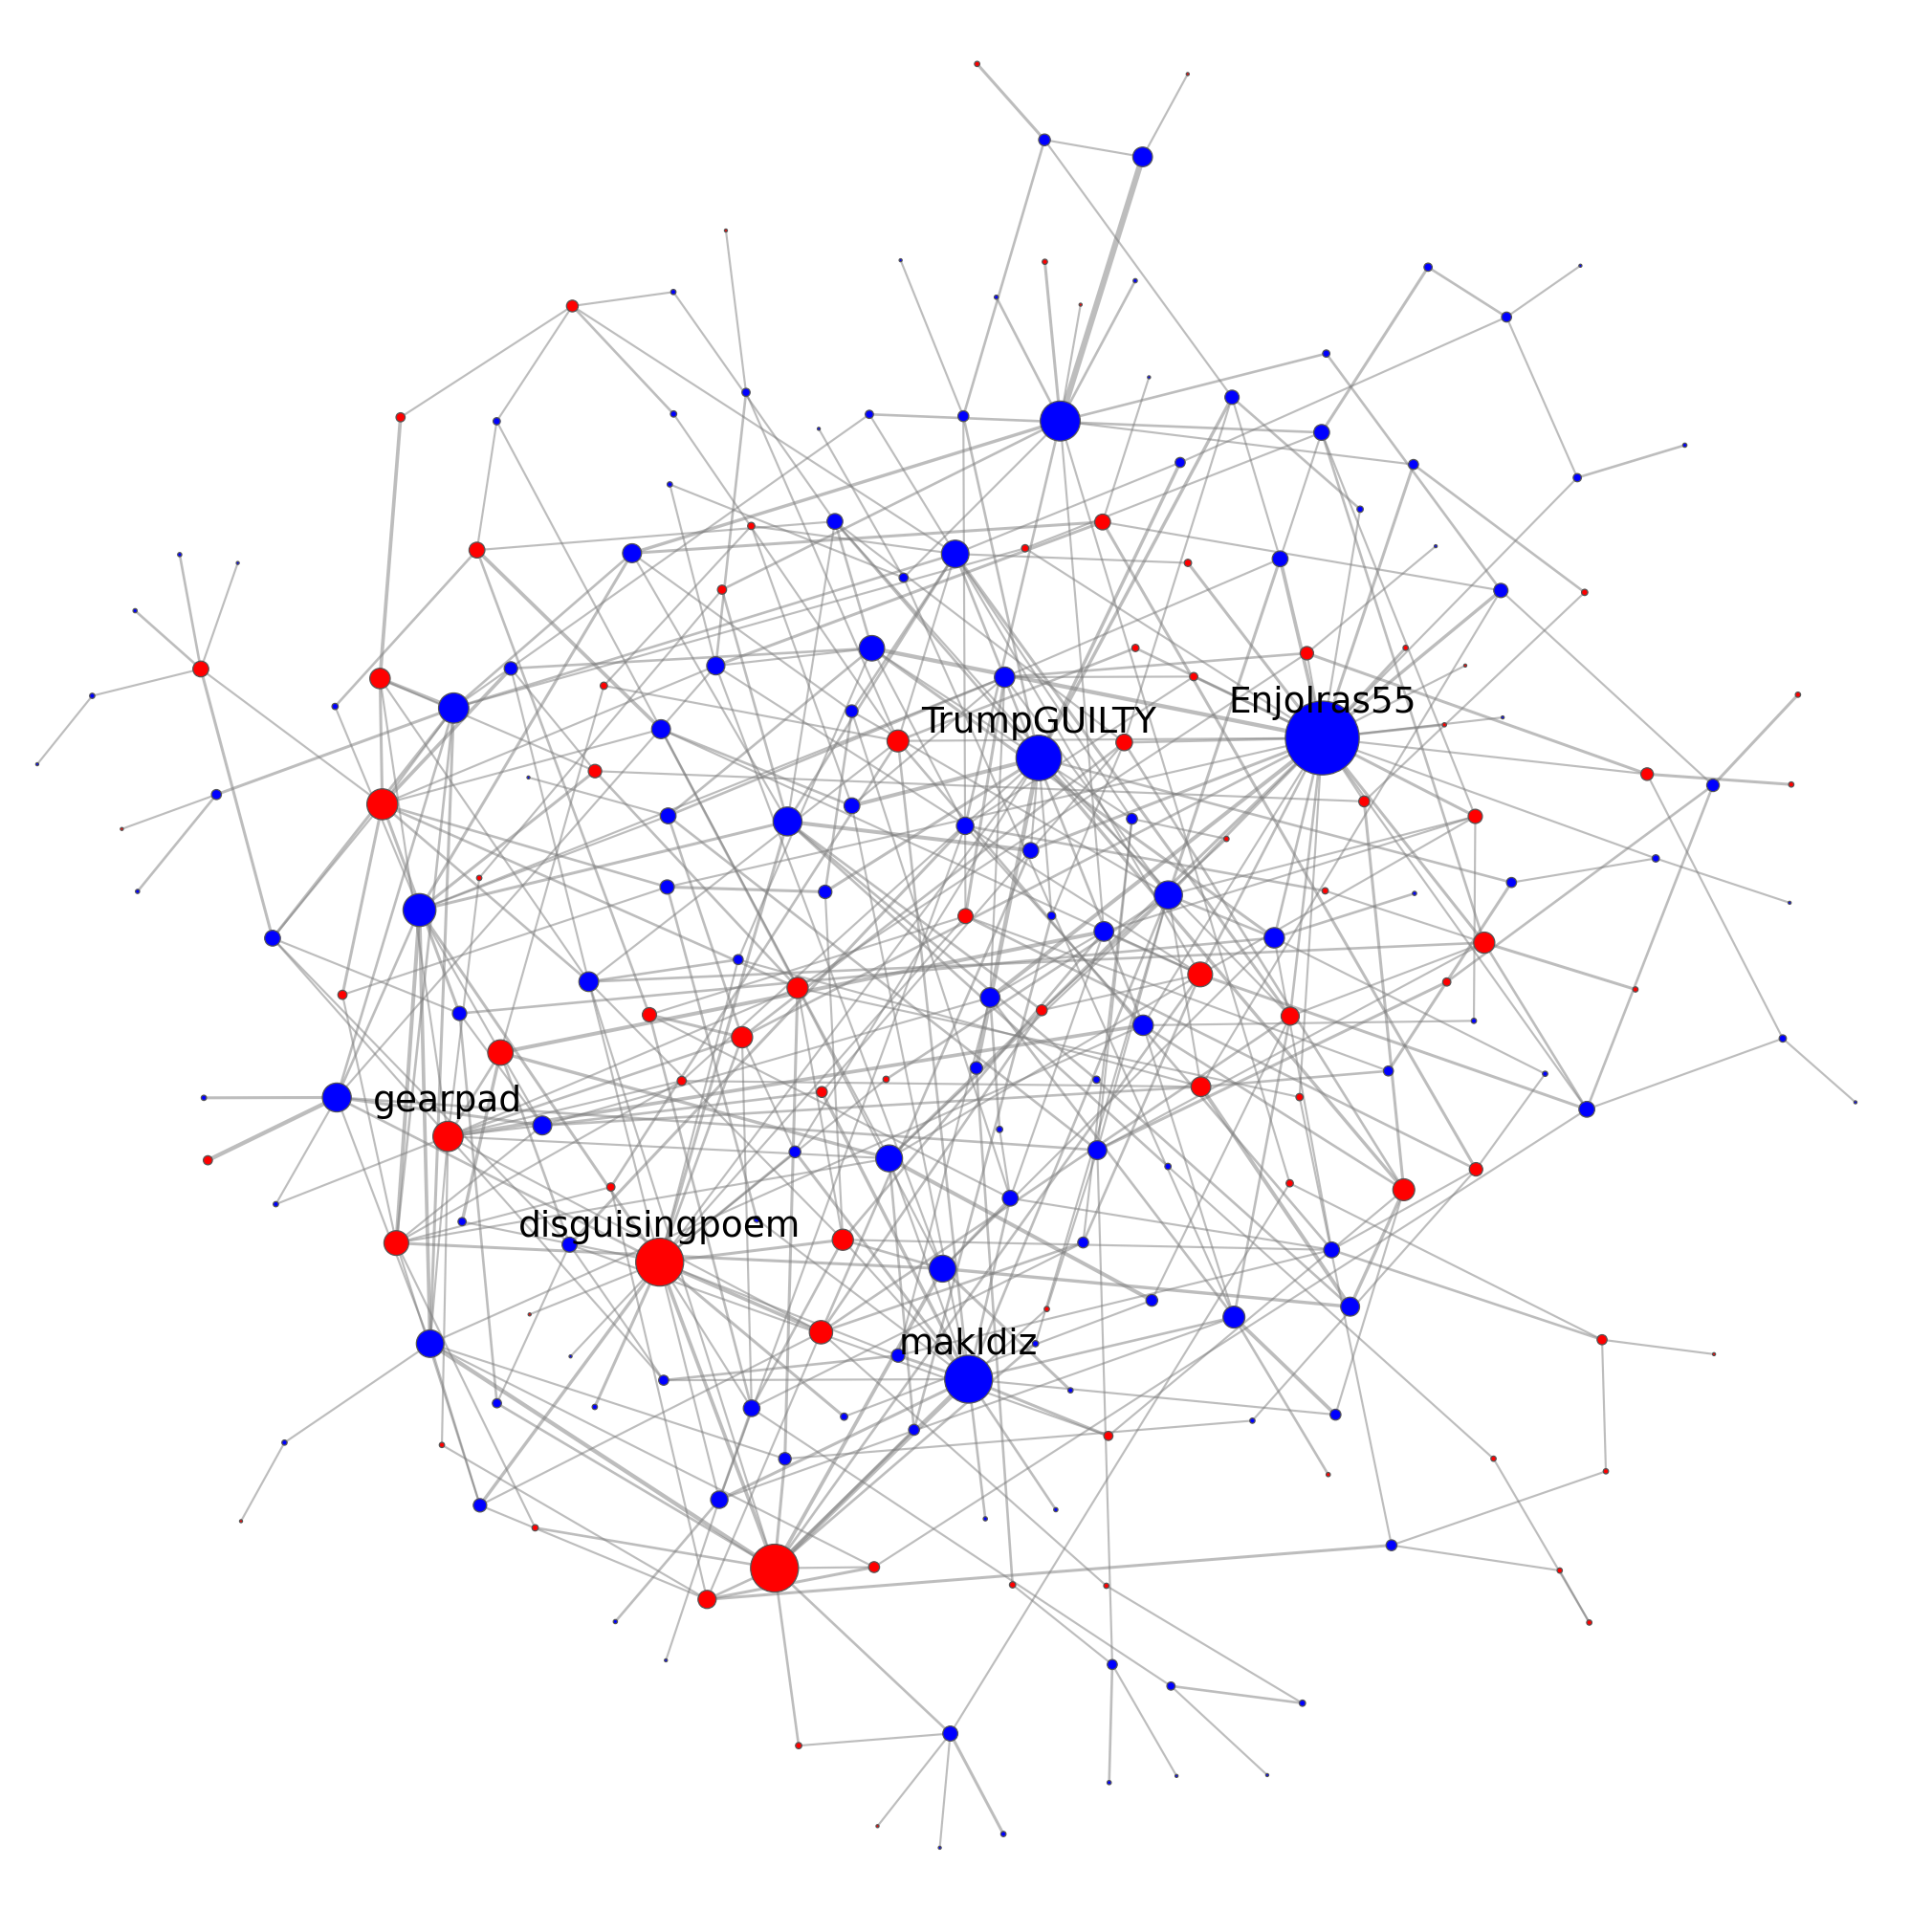

In [738]:
G_U = G_U_copy

H_U = nx.subgraph(G_U, list(partition_dict[13]))
H_U

configuration = {"zoom": 1.3, "node_charge": -100, "node_gravity": 0.32,
                 "link_distance": 15, "link_distance_variation": 0, "node_collision": True,
                 "wiggle_nodes": False, "freeze_nodes": False,
                 "node_fill_color": '#79aaa0', "node_stroke_color": "#555555",
                 "node_label_color": "#000000","node_size": 10,"node_stroke_width": 0.4,
                 "node_size_variation": 0.8, "label_size": 10, "display_node_labels": False,
                 "scale_node_size_by_strength": True,"link_color": "#7c7c7c", "link_width": 2,
                 "link_alpha": 0.5, "link_width_variation": 0.5, "display_singleton_nodes": True,
                 "min_link_weight_percentile": 0,"max_link_weight_percentile": 1}


largest_degree_labels = []
largest_degree_nodes = sorted(H_U.degree, key=lambda x: x[1], reverse=True)[:5]
for i in range(len(largest_degree_nodes)): 
    largest_degree_labels.append(largest_degree_nodes[i][0])

plt.style.use('default')

network, config = nw.visualize(H_U, plot_in_cell_below=False, config = configuration)

fig, ax = nw.draw_netwulf(network, figsize = 20)

for label in largest_degree_labels: 
    nw.add_node_label(ax,network,label, dy = 15, fontsize = 27)

plt.savefig('politics_network_largest_community.svg', bbox_inches='tight')


We observe that the community contains a large number of both red red and blue nodes and that they are relatively interconnected. This suggests that users often interact with others that do not share their political belief, which also supports the general trend observed earlier. 


Lastly we examined if the found modularities were statistically different from 0? We did this by creating 1000 randomized versions of the Reddit network using the DSE algorithm. Then we started by computing the modularity of the "trump/biden" split for for each of them.  

In [671]:
#STATISTISK TEST PÅ TRUMP/BIDEN SPLIT

random_kcnets_original = []
n = 1000
for _ in tqdm(range(n)):
    G_new = nx.double_edge_swap(G_U, nswap = G_U.number_of_edges(),max_tries = G_U.number_of_edges()*100) 
    random_kcnets_original.append(nx_comm.modularity(G_new, [trump, biden]))

100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:49<00:00, 20.37it/s]


In [672]:
print('Avg. Modularity: {} \nStandard deviation: {}'.format(round(np.mean(random_kcnets_original),6), round(np.std(random_kcnets_original),6)))

Avg. Modularity: -0.000591 
Standard deviation: 0.007508


After the random rewiring, the mean modularity is centered around 0. Therefore they don't represent potential communities. This is also expected from a randomly wired network, as described in the theory.

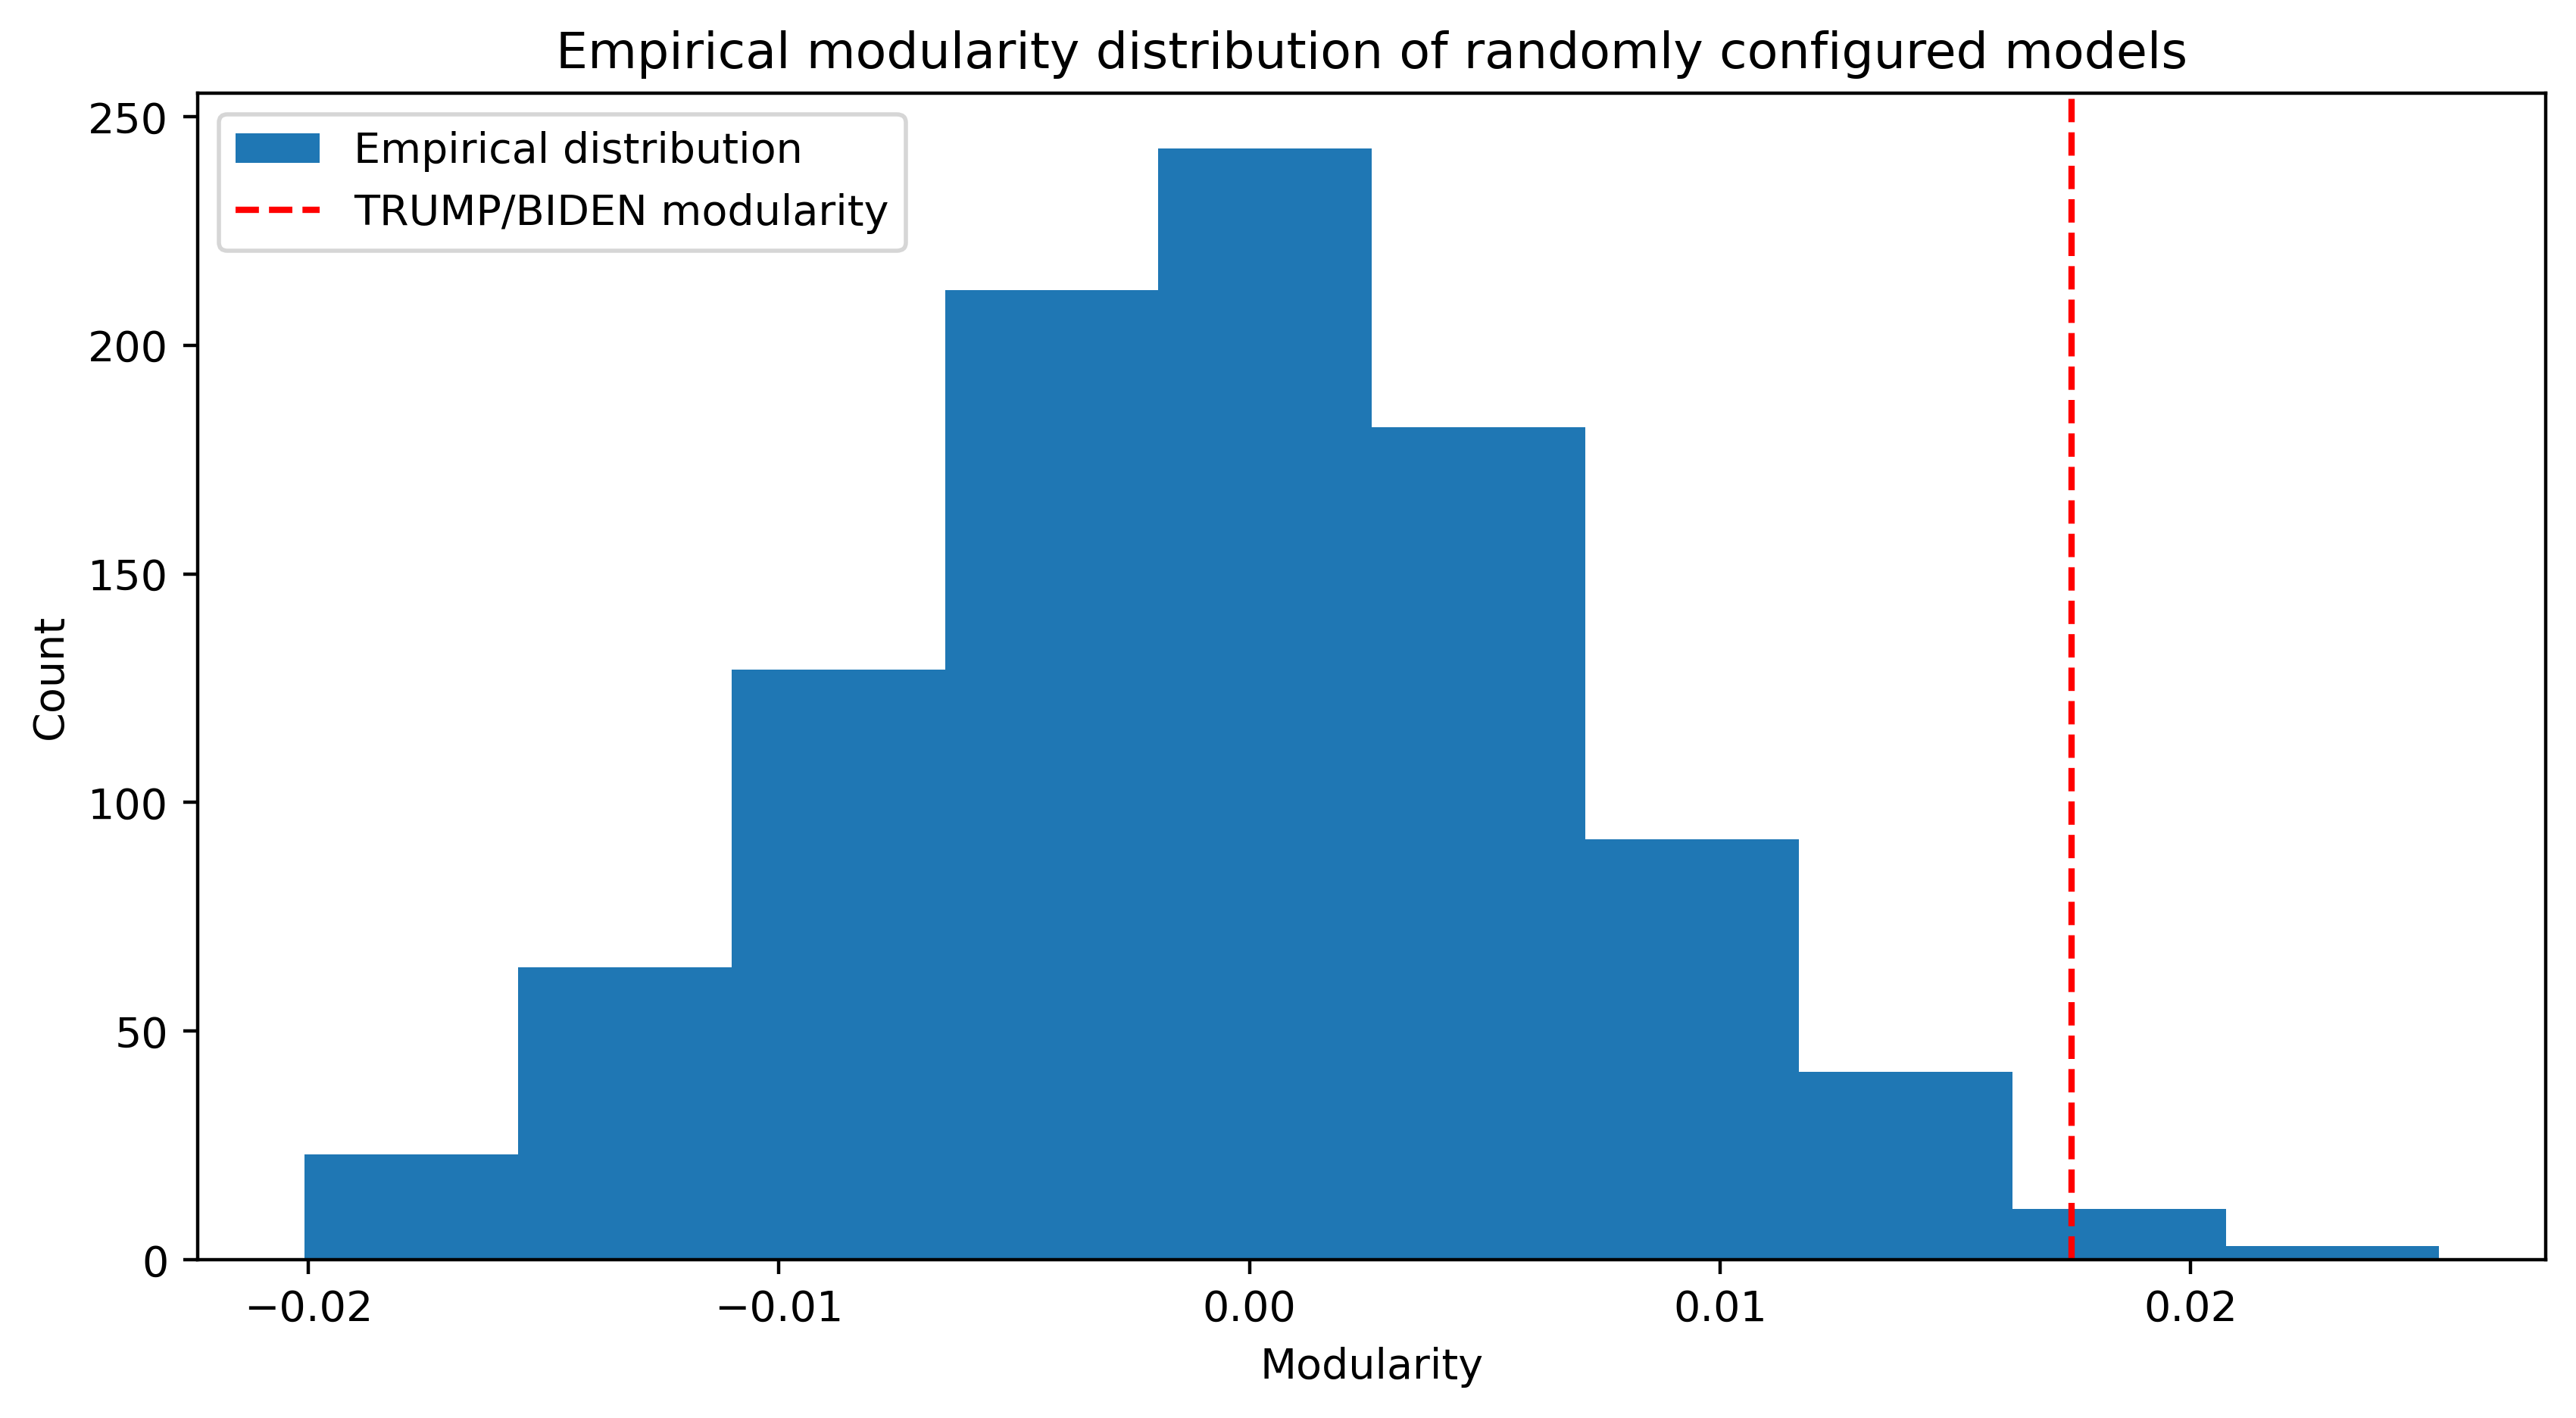

In [735]:
fig, ax = plt.subplots(figsize=(10,5), dpi=400)
ax.hist(random_kcnets_original, label="Empirical distribution", bins=10)
ax.axvline(G_U_modularity, linestyle='--', color='r', label="TRUMP/BIDEN modularity")
ax.set_title("Empirical modularity distribution of randomly configured models")
ax.set_ylabel("Count")
ax.set_xlabel("Modularity")
ax.legend()
plt.savefig('Empirical modularity distribution of randomly configured models_trump_biden.svg', bbox_inches='tight')

Looking at the plot, the modularity of the trump/biden split lies within the emirical modularity distribution for the randomly altered models. This indicates that the edges between the communities of 'trump' and 'biden' are explained by the degree distribution and the connectivity is close to that of a random graph. Therefore the trump/biden split is not a good partitioning as its modularity is not statistically significantly different from 0. 

We then run the same experiment for the Louvain partitioning:

In [674]:
G_U = G_U_copy

#print(Original_G_U_edges == G_U.edges())

#print(G_U.edges() == G_U_copy.edges())


#STATISTISK TEST PÅ LOVAIN SPLIT

random_kcnets_louvain = []
n = 1000
for _ in tqdm(range(n)):
    G_new = nx.double_edge_swap(G_U, nswap = G_U.number_of_edges(),max_tries = G_U.number_of_edges()*100) 
    random_kcnets_louvain.append(nx_comm.modularity(G_new, list(partition_dict.values())))

True
True


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [01:03<00:00, 15.79it/s]


In [675]:
print('Avg. Modularity: {} \nStandard deviation: {}'.format(round(np.mean(random_kcnets_louvain),6), round(np.std(random_kcnets_louvain),6)))

Avg. Modularity: -0.001318 
Standard deviation: 0.004599


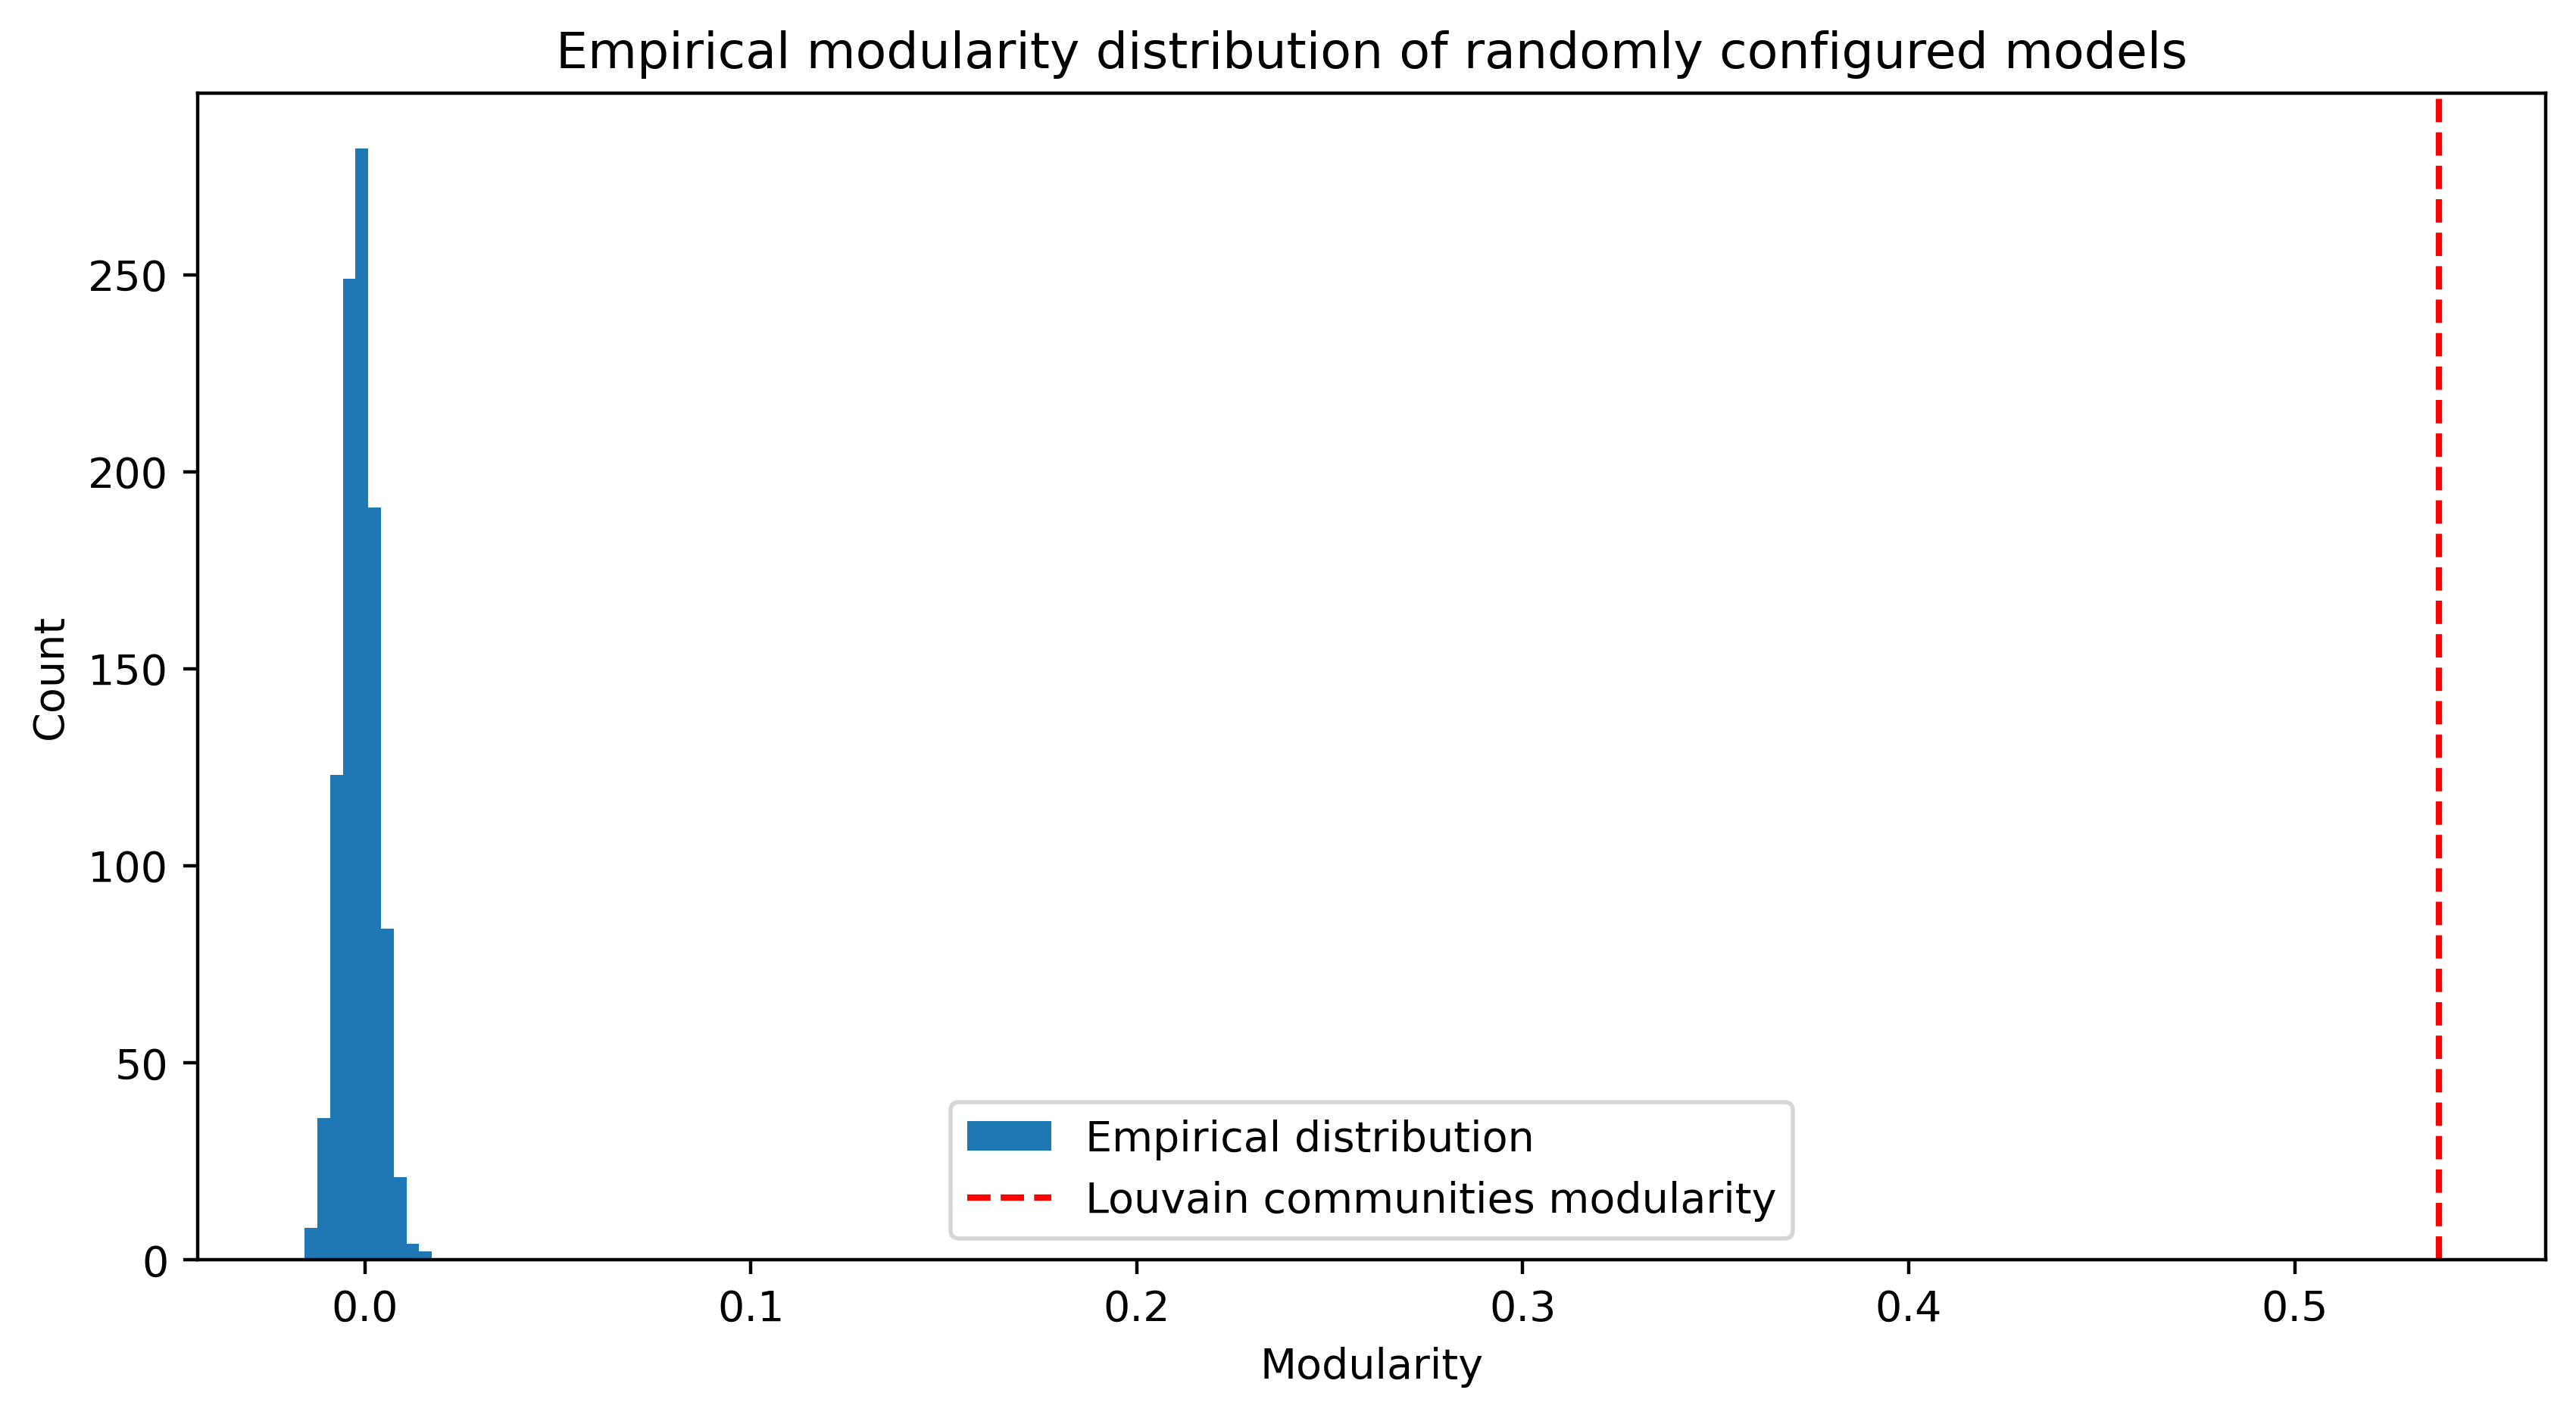

In [679]:
fig, ax = plt.subplots(figsize=(10,5), dpi=400)
ax.hist(random_kcnets_louvain, label="Empirical distribution", bins=10)
ax.axvline(louvain_modularity, linestyle='--', color='r', label="Louvain communities modularity")
ax.set_title("Empirical modularity distribution of randomly configured models")
ax.set_ylabel("Count")
ax.set_xlabel("Modularity")
ax.legend()
plt.savefig('Empirical modularity distribution of randomly configured models_louvain.svg', bbox_inches='tight')

As seen in the plot, none of the 1000 randomly configured networks had a modularity higher than the one observed in the split suggested by the Louvain algorithm. This suggests there are fewer edges between the Louvain communities than one would expect using a randomly connected graph. Therefore the splits calculated by the Louvain algorithm is a good partitioning, and we can conclude that its modularity is statistically significantly different from 0. 